### 0_methods_B_tuning_4_find_MAEs.ipynb  

# Tuning: find Mean Absolute Error of each model run
#### We share this notebook for transparency, but it CANNOT BE EXECUTED as model output from the 3595 tuning runs is not published online.

**Notebook input:**
- parameters_2TU_sampled_after_constraints.csv (from subfolder 0_methods_B_tuning_files)
- parameters_KDE_sampled_after_constraints.csv (from subfolder 0_methods_B_tuning_files)
- parameters_3P5_sampled_after_constraints.csv (from subfolder 0_methods_B_tuning_files)
- model output of the tuning runs (not provided)

**Notebook output (saved in subfolder 0_methods_B_tuning_files):**
- total_table_ensemble_2TU.csv
- total_table_ensemble_KDE.csv
- total_table_ensemble_3P5.csv

**Notebook comments:**  
- This notebook does the postprocessing of the tuning runs and computes Mean Absolute Errors (MAEs) of model versus observations.  
- The resulting MAEs are saved in a total_table file together with the medians and mean residence times (MRTs).
- We share this notebook for transparency, but it cannot be executed as model output from the 3595 tuning runs is not published online.

**General information:**
- This notebook was published in the zenodo repository https://doi.org/10.5281/zenodo.10622403 along with the paper:

   - Jeemijn Scheen, Jörg Lippold, Frerk Pöppelmeier, Finn Süfke and Thomas F. Stocker. Promising regions for detecting the overturning circulation in Atlantic 231Pa/230Th: a model-data comparison. Paleoceanography and Paleoclimatology, 2025.
- Code author for this notebook: Jeemijn Scheen

In [20]:
########### SETTINGS ###########
# choose from 2TU KDE 3P5
ensemble = 'KDE'
################################

# Set up notebook  
**Easiest:** load conda environment for which this notebook worked.  
**Just use environment.yml (present in this folder) and follow** https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

In [9]:
from pathlib import Path         # Path objects to avoid inter-platform trouble in file paths
import platform

########## SET FILE PATHS ######################################
# KEEP THE Path() FUNCTION AND USE FORWARD SLASHES '/' ON EVERY OPERATING SYSTEM
savedir = Path('./figures/')      # folder for saving figures & other output; (empty) directory needed
obsdir = Path('./data/')          # obs. data is loaded from here
tuning_files_dir = Path('./0_methods_B_tuning_files/')   # location of parameters_XXX_sampled_after_constraints.csv files
modeldir = Path('./modeloutput/') # model output is loaded from here
#############################################

## CHECK FILEPATHS
# expand paths because np.loadtxt can't handle home directory ~
savedir = savedir.expanduser()
obsdir = obsdir.expanduser()
modeldir = modeldir.expanduser()
tuning_files_dir = tuning_files_dir.expanduser()
def check_dir(path):
    if not path.exists():
        raise Exception('File path ' + str(path) + ' does not exit. Correct or create first.')
check_dir(savedir)
check_dir(obsdir)
check_dir(modeldir)
check_dir(tuning_files_dir)

## IMPORT PACKAGES
# first time install missing packages via $conda install numpy OR $pip3 install numpy (be consistent)
import numpy as np
import xarray as xr                            # $conda install -c anaconda -n cartopy xarray; needs some time
import pandas as pd
import importlib as imp                        # to import user-defined functions; renaming new name to name of deprecated package 'imp'
import math                                    # math.e or math.exp()
import xesmf as xe                             # regridding; install via conda-forge channel e.g. !conda install -c conda-forge xesmf -y

# plot-related packages:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace
import matplotlib.cm as cmp                    # colormaps
import cmcrameri.cm as cmcr                    # better colour maps (https://www.fabiocrameri.ch/colourmaps/); $conda install -c conda-forge cmcrameri
import cartopy.crs as ccrs
import seaborn as sns

## CHECK PYTHON VERSION
if 1/2 == 0:
    raise Exception("You are using python 2. Please use python 3 for a correct display of the figures.") 

## PLOT SETTINGS
# larger labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# set a random run as control simulation; doesn't matter as only model grid is used
fnctrl = modeldir / 'CTRL_NEWNR'

# in the model output, simulation year 0 is called 1765 CE (pre-industrial)
spinup_yr = 1765

## INFORMATION ON ENSEMBLES
# only used for ensemble 'KDE':
kdes_runs_batch1 = list(range(0,20))+list(range(40,48))
kdes_runs_batch2 = list(range(20,40))+list(range(48,56))
kdes_runs_batch3 = list(range(56,84))

all_run_nrs = {'2TU' : range(0,511),
               '3P5' : range(0,3000),
               'KDE' : kdes_runs_batch1+kdes_runs_batch2+kdes_runs_batch3}

## LOAD USER-DEFINED FUNCTIONS
import functions as f                          # my own functions; call via f.function_name()

In [4]:
imp.reload(f)   # shows how to reload functions after editing functions.py w/o kernel restart

<module 'functions' from '/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py'>

# Load observations 
Dissolved Pa, Th from GEOTRACES IDP2021, Deng et al., Ng et al. and Pavia et al:

In [7]:
# load geotraces observations
fnobs = obsdir / 'Pad_Thd_IDP2021.txt'
obs_d_geotraces_incl_arctic = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', 
                                                  drop_meta_data=True, good_quality=True)
obs_d_geotraces = obs_d_geotraces_incl_arctic[~obs_d_geotraces_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

# load other dissolved observations from 3 additional studies
obs_d_deng = f.get_obs_other(obsdir / 'Deng2018Pad_Thd_formatted_uBq_per_kg.csv') # is geovide
obs_d_ng = f.get_obs_other(obsdir / 'Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv')
for var in ['Pad','Pad_err','Thd','Thd_err']:
    # convert dpm/1000kg to uBq/kg; using 1 dpm = 1/60 * 1e6 uBq
    obs_d_ng[var] = obs_d_ng[var] / 60.0 * 1e3  
obs_d_pavia = f.get_obs_other(obsdir / 'Pavia2020Pad_Thd_formatted_uBq_per_kg.csv')

# combine all dissolved data
obs_d = pd.concat([obs_d_geotraces,obs_d_deng,obs_d_ng,obs_d_pavia], join='outer')
obs_d_incl_arctic = pd.concat([obs_d_geotraces_incl_arctic,obs_d_deng,obs_d_ng
                               ,obs_d_pavia], join='outer')  # for completeness; not used

[obs_d, obs_d_ave, obs_d_ave_num] = f.obs_to_model_grid(obs_d, fnctrl)

/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py:700: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(fnobs, sep='\t', header=39, dtype={'Cruise Aliases':'str'})


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2166  rows after deleting nans.
Reduced dataset from  129  rows to  129  rows after deleting nans.
Reduced dataset from  20  rows to  20  rows after deleting nans.
Reduced dataset from  126  rows to  126  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


In [23]:
## define basins/cruises of interest
# using obs_d since obs_p would only give a subset of that
cruises_all = np.unique(obs_d.cruise)        # already excludes Arctic cruises

# only 1 basin incl its SO sector
cruises_Atl = ['GA02', 'GAc02', 'GA03', 'GAc03', 'GA10','GIPY04', 'GIPY05', 
               'deng', 'ng'] # deng=geovide
cruises_Pac = ['GP16', 'GPc01', 'GSc02', 'pavia']

# SO (Southern Ocean)
cruises_SO = ['GSc02','GIPY04', 'GIPY05','GIpr05', 'pavia'] 
# chosing here the definition that GA10 is not SO

# for testing purposes; not used
cruises_Arctic = ['GN01', 'GN02', 'GN03', 'GN04']  
cruises_Labr = ['GN02']

Particle-bound Pa, Th from GEOTRACES IDP2021:

In [24]:
# LOAD WITH NEW COLUMNS Pap, Thp THAT COMBINE SPT,LPT,TP and 
# extra columns Pap_type, Thp_type which keep track of the origin
# also with only keeping good quality measurements
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'

obs_p_incl_arctic = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='combined', good_quality=True)
obs_p = obs_p_incl_arctic[~obs_p_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

Reduced dataset from  102686  rows to  860  rows after deleting nans.
Reduced dataset from  1009  rows to  1003  rows after deleting nans.


# Load model run IDs and parameters
Here we only load the run IDs (which determine the runnames) and the parameters.  
It is combined into a table, to which we later add the MAEs etc.  
We do not need to load the model runs here, but for efficiency this is done 1 by 1 during the calculations below.  

In [21]:
# read in the csv on which the tuning runs were based
# this already gives us columns run_ID and the 13 parameters that were adjusted
# using var 'ensemble' as set on top of this notebook
total_table = pd.read_csv(tuning_files_dir / ('parameters_'+ensemble+'_sampled_after_constraints.csv'))

total_table.rename(columns={'# setID':'run_ID', '﻿BGC_PaThWs':'PaThWs', 'BGC_PaThWs':'PaThWs', 
                            'BGC_PaDesConst':'PaDesConst', 'BGC_ThDesConst':'ThDesConst', 
                            'BGC_sigmaPaPOC':'sigmaPaPOC', 'BGC_sigmaPaCa':'sigmaPaCa', 
                            'BGC_sigmaPaOp':'sigmaPaOp', 'BGC_sigmaPaDu':'sigmaPaDu', 'BGC_sigmaPaNeph':'sigmaPaNeph', 
                            'BGC_sigmaThPOC':'sigmaThPOC', 'BGC_sigmaThCa':'sigmaThCa', 
                            'BGC_sigmaThOp':'sigmaThOp', 'BGC_sigmaThDu':'sigmaThDu', 'BGC_sigmaThNeph':'sigmaThNeph'}, 
                   inplace=True) # BGC_PaThWs column name contained still DOF unicode char

# add a column with the runname for completeness (corresponding parameter files, .out files and output files carry this name)
#     N.B. technically speaking: with runname we mean parameterfilesname here. We dont mean executablename, 
#     since the executable is the same for the entire ensemble.
total_table.insert(1, 'runname', [f.runname(n, ID=True, ensemble=ensemble) for n in total_table.run_ID]) # add new column runnames after column 1

In [22]:
total_table

,run_ID,runname,sigmaPaPOC,sigmaPaCa,sigmaPaOp,sigmaPaDu,sigmaPaNeph,sigmaThPOC,sigmaThCa,sigmaThOp,sigmaThDu,sigmaThNeph
0,1000,3P51000_PI,0.041664,0.027694,0.003618,0.025605,0.007500,0.171562,0.108154,0.184250,0.007954,0.079776
1,1001,3P51001_PI,0.032777,0.009552,0.091571,0.009172,0.007582,0.058784,0.367628,0.110147,0.118523,0.001203
2,1002,3P51002_PI,0.030240,0.054182,0.179840,0.022319,0.020960,0.134542,1.716227,0.130726,0.103457,0.045642
3,1003,3P51003_PI,0.011025,0.064817,0.006240,0.034878,0.051747,0.235281,1.807028,0.076880,0.118701,0.054947
4,1004,3P51004_PI,0.030462,0.007852,0.149346,0.003379,0.002312,0.042884,0.332646,0.213407,0.034688,0.099854
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,3995,3P53995_PI,0.020129,0.064073,0.158277,0.042453,0.050615,0.033920,1.832027,0.063243,0.046403,0.090363
2996,3996,3P53996_PI,0.024468,0.070220,0.134154,0.002926,0.007099,0.230160,1.076886,0.119036,0.044523,0.011031
2997,3997,3P53997_PI,0.017211,0.070603,0.045437,0.028234,0.011729,0.263597,0.944984,0.210549,0.018470,0.021141
2998,3998,3P53998_PI,0.025439,0.030531,0.172991,0.042291,0.023682,0.107265,0.898596,0.216407,0.023834,0.117130


# Compute Mean Residence Time (MRT)
Saved MRT is based on average of last 50 years of run. Also checks that in equilibrium: otherwise MRT=nan is added to total_table.  

**Expected residence time:**   
Marchal et al. 2000 & Siddall et al. 2005 cite Yu et al. 1996: Pa ~200 yr; Th ~30yr  
Rempfer et al. 2017 (cites multiple): Pa 100-200 yr; Th few decades  
**Missiaen et al. 2020 (cites Henderson et al. 2003): Pa 50-200 yr; Th 10-40 yr**  

In [13]:
# ================= TAKES A WHILE (< 5 MIN)========================

## Load MEAN RESIDENCE TIME for all runs
runs = [f.runname(n, ensemble=ensemble) for n in all_run_nrs[ensemble]]
modelled_mrt = f.load_var_multiple_runs(['Mrt_Pa_bac','Mrt_Th_bac'], 
                                        'timeseries_inst', modeldir, runs, spinup_yr=spinup_yr)  # cant execute (tuning output not provided)
sec_to_yr = 1.0 / (365.25*24*3600)

equilibrium residence time of Pa: 67.7 yr
equilibrium residence time of Th: 18.3 yr



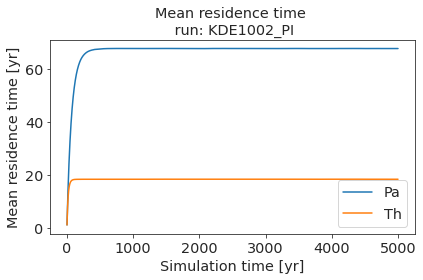

In [14]:
# PLOT mean residence time for a specific run

######### SETTINGS ############### 
n = 2  # run number of ensemble
##################################

ds = modelled_mrt[f.runname(all_run_nrs[ensemble][n], ensemble=ensemble)]

sns.set_style('ticks')
fig, ax = plt.subplots(1)

ax.set_title('Mean residence time \n run: ' + f.runname(all_run_nrs[ensemble][n], ensemble=ensemble))
ax.plot(ds.Mrt_Pa_bac.time, ds.Mrt_Pa_bac * sec_to_yr, label='Pa')
ax.plot(ds.Mrt_Th_bac.time, ds.Mrt_Th_bac * sec_to_yr, label='Th')
ax.legend(loc='lower right')
ax.set_xlabel('Simulation time [yr]')
ax.set_ylabel('Mean residence time [yr]')
plt.tight_layout()
plt.savefig(savedir / ('residence_time_run_' + f.runname(all_run_nrs[ensemble][n], ensemble=ensemble) + '.pdf'))

# diagnose residence time at last 100 years
print('equilibrium residence time of Pa:', np.round((ds.Mrt_Pa_bac[-100:-1] * sec_to_yr).mean().item(),1), 'yr')
print('equilibrium residence time of Th:', np.round((ds.Mrt_Th_bac[-100:-1] * sec_to_yr).mean().item(),1), 'yr\n')

In [15]:
# ================= TAKES A WHILE (< 5 MIN)========================

## check if runs are in equilibrium & insert MRT to table

###### SETTINGS #########################
# what is the 'internal variability' of the above curve? (trial and error by eye gives 0.1 yr)
delta_significant = 0.1  # in yr; a difference is significant if > delta_significant
# hardcoded: 50 yr average of MRT at end is saved
#########################################

# fill lists with information on the way
mrts_Pa = []
mrts_Th = []
for n in all_run_nrs[ensemble]:
    ds = modelled_mrt[f.runname(n, ensemble=ensemble)]
    # t1 is 200 yr before end;     t2 is at end (50 yr average)
    mrt_Pa_t1 = ds.Mrt_Pa_bac.isel(time=-200) * sec_to_yr
    mrt_Pa_t2 = ds.Mrt_Pa_bac.isel(time=slice(-50,-1)).mean() * sec_to_yr
    mrt_Th_t1 = ds.Mrt_Th_bac.isel(time=-200) * sec_to_yr 
    mrt_Th_t2 = ds.Mrt_Th_bac.isel(time=slice(-50,-1)).mean() * sec_to_yr

    if abs(mrt_Pa_t2 - mrt_Pa_t1) < delta_significant:
        # simulation ran into equilibrium
        mrts_Pa.append(mrt_Pa_t2.item())
        mrts_Th.append(mrt_Th_t2.item())
    else:
        # save nan instead as a sign that this run is not in equilibrium
        mrts_Pa.append(np.nan)
        mrts_Th.append(np.nan)        
        print("MRT is not constant i.e. no equilibrium for run nr", n, "which has runname", f.runname(n,ensemble=ensemble))
        
print('All',len(all_run_nrs[ensemble]),'runs were succesfull IF this is the first print statement. Done.')
# all runs of 2TU are in equilibrium!

# add resulting MRTs to table
total_table.insert(2, 'MRT_Pa', mrts_Pa) # add new column MRT_Pa after column 2
total_table.insert(3, 'MRT_Th', mrts_Th) 

All 84 runs were succesfull IF this is the first print statement. Done.


- Ensemble 2TU: residence times have the correct range inside them (but span more)
- Ensemble 3TU: residence times have the correct range inside them (but span more)

In [17]:
## delete objects again to save memory
del modelled_mrt

# Compute median

In [18]:
# COMPUTE median
####### TAKES CA. 5 MINS ########

######### SETTINGS: ########
run_nrs = all_run_nrs[ensemble]    # defined at top of notebook
############################

# print observations median of Pad, Thd, Pap, Thp as comparison
print('median of Pad obs:', obs_d.Pad.median(), 'uBq/kg')
print('median of Thd obs:', obs_d.Thd.median(), 'uBq/kg')
if 'obs_p' in globals():
    print('median of Pap obs:', obs_p.Pap.median(), 'uBq/kg')
    print('median of Thp obs:', obs_p.Thp.median(), 'uBq/kg\n')

## load all model data
runnames = [f.runname(nr=i, ensemble=ensemble, ID=False) for i in run_nrs]
load_vars = ['Pad','Thd','Pap','Thp','rho_SI']
data_fulls = f.load_var_multiple_runs(variables=load_vars, file_type='full_ave', 
                                      folder=modeldir, runs=runnames)  # cant execute (tuning output not provided); still model units of dpm/m3

## loop over runs and fill information on the way
median_Pad = []
median_Thd = []
median_Pap = []
median_Thp = []
for i,n in enumerate(run_nrs):
    run = f.runname(nr=n, ensemble=ensemble, ID=False)
    
    # convert model units dpm/m3 to uBq/kg
    obj = data_fulls[run].isel(time=-1)                                 # output of this run, still in dpm/m3
    obj = f.model_to_sw_unit(obj, data_fulls[run].rho_SI.isel(time=-1)) # to uBq/kg

    # compute and save median
    median_Pad.append(obj.Pad.median().item())
    median_Thd.append(obj.Thd.median().item())
    median_Pap.append(obj.Pap.median().item())
    median_Thp.append(obj.Thp.median().item())
    
# add results to table
total_table.insert(4, 'median_Pad', median_Pad)
total_table.insert(5, 'median_Thd', median_Thd)
total_table.insert(6, 'median_Pap', median_Pap)
total_table.insert(7, 'median_Thp', median_Thp)

# delete (large) datasets again to save memory
del data_fulls

median of Pad obs: 2.592 uBq/kg
median of Thd obs: 4.737377 uBq/kg
median of Pap obs: 0.030676 uBq/kg
median of Thp obs: 0.5572295 uBq/kg



# Compute MAEs
We compute Mean Absolute Errors as a measure of how well each model run fits the observations. MAEs have the advantage over RMSEs to be less influenced by outliers, and are a bit more intuitive to interpret because they have no square root.  

Formula:  
$$MAE = \frac{\sum_{l=1}^N a_l \cdot |sim_l - obs_l|}{\sum_{l=1}^N a_l}$$
where $|x|$ is the absolute value of $x$, and $l$ is a model grid cell (lat, lon, z) where observations are present. If multiple observations occur in 1 grid cell, they are averaged and the result is saved as $obs_l$ (obs_ave in the code). Output of model grid cells where no observations are present is ignored. The unit of MAE is the same as the unit of obs/models.   

Weights:  
We weight the MAE by the uncertainty in the observations:  
$$a_l = \frac{1}{err_l}$$
where $err_l$ is the uncertainty reported in the observations. Note that $a_l \to \infty$ when $err_l\to 0$, but we checked that none of the errors in Pad and Thd is literally 0. 
This formula is used in the function find_weights().  

We will now use obs_ave together with every model run via the get_sim() function to compute the MAE of model-obs misfit. Care is taken that both objects are pandas dataframes (both xarray would have been possible as well but not implemented). The MAE is weighted by observational uncertainties, as described in the formulas above. We also provide the unweighted MAEs (not used in the paper).

In [43]:
## prepare: load obs 

## load observations again to be sure to have the right version / desired subset

# dissolved
# load geotraces observations
fnobs = obsdir / 'Pad_Thd_IDP2021.txt'
obs_d_geotraces_incl_arctic = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', 
                                                  drop_meta_data=True, good_quality=True)
obs_d_geotraces = obs_d_geotraces_incl_arctic[~obs_d_geotraces_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

# load other dissolved observations from 3 additional studies
obs_d_deng = f.get_obs_other(obsdir / 'Deng2018Pad_Thd_formatted_uBq_per_kg.csv') # is geovide
obs_d_ng = f.get_obs_other(obsdir / 'Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv')
for var in ['Pad','Pad_err','Thd','Thd_err']:
    # convert dpm/1000kg to uBq/kg; using 1 dpm = 1/60 * 1e6 uBq
    obs_d_ng[var] = obs_d_ng[var] / 60.0 * 1e3  
obs_d_pavia = f.get_obs_other(obsdir / 'Pavia2020Pad_Thd_formatted_uBq_per_kg.csv')

# combine all dissolved data
obs_d = pd.concat([obs_d_geotraces,obs_d_deng,obs_d_ng,obs_d_pavia], join='outer')
obs_d_incl_arctic = pd.concat([obs_d_geotraces_incl_arctic,obs_d_deng,obs_d_ng
                               ,obs_d_pavia], join='outer')  # for completeness; not used
[obs_d, obs_d_ave, obs_d_ave_num] = f.obs_to_model_grid(obs_d, fnctrl)

# particle-bound
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'
obs_p = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='combined', good_quality=True)
[obs_p, obs_p_ave, obs_p_ave_num] = f.obs_to_model_grid(obs_p, fnctrl) # this accidentally still contained the Arctic (only data for GN01 Thp, which have reasonable values)

/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py:700: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(fnobs, sep='\t', header=39, dtype={'Cruise Aliases':'str'})


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2166  rows after deleting nans.
Reduced dataset from  129  rows to  129  rows after deleting nans.
Reduced dataset from  20  rows to  20  rows after deleting nans.
Reduced dataset from  126  rows to  126  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Reduced dataset from  102686  rows to  860  rows after deleting nans.
Reduced dataset from  1009  rows to  1003  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


In [ ]:
## prepare: compute weights

# load one example run; only used for volume of grid cells
runid = all_run_nrs[ensemble][0] + 1000  # must be ID so plus 1000
    
# dissolved
[res_d_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_d_ave, 
                                      ensemble=ensemble, convert_unit_to_obs=True) # cant execute (tuning output not provided)
# find weights
[weights_unc_Pad, weights_unc_Thd] = f.find_weights(obs_d_ave, res_entire, volume=False, uncertainty=True)

# particle-bound 
# => has other res_table since obs are at other locations: other model grid cells are selected
[res_p_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_p_ave, 
                                      ensemble=ensemble, convert_unit_to_obs=True) # cant execute (tuning output not provided)
# find weights
[weights_unc_Pap, weights_unc_Thp] = f.find_weights(obs_p_ave, res_entire, volume=False, uncertainty=True)

### Get MAE for 1 example run

In [25]:
# first load 1 model run

###### SETTINGS #########################
n = 5  # set run_nr
#########################################

runid = all_run_nrs[ensemble][n] + 1000   # must be ID so plus 1000
    
[res_d_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_d_ave, 
                                      ensemble=ensemble, convert_unit_to_obs=True)
[res_p_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_p_ave, 
                                      ensemble=ensemble, convert_unit_to_obs=True)
# res_entire gives entire model data in xarray(all 3D variables including also Pad, Thd, Pap, Thp)
# res_d/p_table gives pandas dataframe/table with columns Pad,Thd resp. Pap,Thp; only containing grid cells where obs are 
#               available; using index of obs_ave (column names of obs_ave determine whether Pad,Thd or Pap,Thp is of interest)

In [ ]:
# compute MAE for that example run without weights
# NOTE: not used in the paper, but provided as well
print('MAE without weights for runid', runid,':')
print('Pad:')
this_MAE = f.calc_mae(model=res_d_table.Pad, observation=obs_d_ave.Pad, weights=None, verbose=True)
print('Thd:')
this_MAE = f.calc_mae(model=res_d_table.Thd, observation=obs_d_ave.Thd, weights=None, verbose=True)
print('Pap:')
this_MAE = f.calc_mae(model=res_p_table.Pap, observation=obs_p_ave.Pap, weights=None, verbose=True)
print('Thp:')
this_MAE = f.calc_mae(model=res_p_table.Thp, observation=obs_p_ave.Thp, weights=None, verbose=True)
print('\n')

# NOTE: version used in the paper
print('MAE with uncertainty weights for runid', runid,':')
print('Pad:')
this_MAE = f.calc_mae(model=res_d_table.Pad, observation=obs_d_ave.Pad, weights=weights_unc_Pad, verbose=True)
print('Thd:')
this_MAE = f.calc_mae(model=res_d_table.Thd, observation=obs_d_ave.Thd, weights=weights_unc_Thd, verbose=True)
print('Pap:')
this_MAE = f.calc_mae(model=res_p_table.Pap, observation=obs_p_ave.Pap, weights=weights_unc_Pap, verbose=True)
print('Thp:')
this_MAE = f.calc_mae(model=res_p_table.Thp, observation=obs_p_ave.Thp, weights=weights_unc_Thp, verbose=True)

## Get MAE for all runs

In [25]:
######### COMPUTE ALL DESIRED MAEs: TAKES A LONG WHILE ###########

###### SETTINGS ######
# define all MAEs to be computed as fourplets and name them (without the _Pad, _Thd)
# fourplets (cruises, wo_surface, weighted_vol, weighted_unc) 
MAE_tasks = {'MAE_unc_weights':(cruises_all,False,False,True), 
             'MAE_no_weights':(cruises_all,False,False,False)}
        
model_run_nrs = all_run_nrs[ensemble]    # takes for 2TU: ca. 10 min x number of tasks
######################

modelrunIDs = np.asarray(model_run_nrs) + 1000  # must be ID so plus 1000

print('--- NUMBER OF TASKS: GOING TO COMPUTE', len(MAE_tasks), 'different versions of MAEs (actually x 4 for Pad,Thd,Pap,Thp).')

MAE_results = {}
counter = 0
for key in MAE_tasks:
    (cruises, wo_surface, weighted_vol, weighted_unc) = MAE_tasks[key]
    
    [junk, this_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises=cruises, wo_surface=wo_surface)
    [junk, this_obs_p_ave, junk2] = f.subset_of_obs(obs_p, fnctrl, cruises=cruises, wo_surface=wo_surface)
    [MAEs_task_Pad, MAEs_task_Thd, MAEs_task_Pap, MAEs_task_Thp] = f.calc_all_MAEs(this_obs_d_ave, this_obs_p_ave, 
                                                                                   modelrunIDs=modelrunIDs, modeldir=modeldir,
                                                                                   ensemble=ensemble, weighted_vol=weighted_vol, 
                                                                                   weighted_unc=weighted_unc, verbose=False) # cant execute (tuning output not provided)
    MAE_results[key+'_Pad'] = MAEs_task_Pad
    MAE_results[key+'_Thd'] = MAEs_task_Thd
    MAE_results[key+'_Pap'] = MAEs_task_Pap
    MAE_results[key+'_Thp'] = MAEs_task_Thp
    
    counter += 1
    print('--- FINISHED TASK NUMBER', counter, ' ---')

print('...FINISHED!')
# if ERROR: cruises objects are defined a few cells above

--- NUMBER OF TASKS: GOING TO COMPUTE 2 different versions of MAEs (actually x 4 for Pad,Thd,Pap,Thp).
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Going to compute MAE_Pad, MAE_Thd, MAE_Pap, MAE_Thp for 84 model runs.
--- FINISHED TASK NUMBER 1  ---
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Going to compute MAE_Pad, MAE_Thd, MAE_Pap, MAE_Thp for 84 model runs.
--- FINISHED TASK NUMBER 2  ---
...FINISHED!


# Export result
The next notebook will explore the result to find the best fits.

In [29]:
# add all results to total_table
col = 8  # start inserting from column 8, because the last column inserted above is at position 7

for key in MAE_results:
    total_table.insert(col, key, MAE_results[key])
    col += 1

In [31]:
# export table to csv
total_table.to_csv(savedir / ('total_table_ensemble_' + ensemble + '.csv'), index=False)